Data Available in :https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
import graphviz
import  dask.dataframe as dd
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import folium # open street map
import matplotlib
#matplotlib.use('nbagg: It uses protocall which makes plot more interactive like max in and max out
matplotlib.use('nbagg')
from matplotlib import rcParams # size of params
import time
import datetime
#this library is used while we  calculate the  stight line  distance between two (lan,lon  pairs in miles
import gpxpy.geo

from sklearn.cluster import MiniBatchKMeans , KMeans
import math
import pickle
import os

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/RakeshS/Anaconda3/Library/bin/graphviz'
#C:\Users\RakeshS\Anaconda3\Library\bin\graphviz

import xgboost  as xgb

from sklearn.ensemble  import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#MinGW is a port of the free GCC compiler to Windows. It allows anyone to download and compile code in
#several languages (C, C++, ADA, Fortran and Java) for native Windows (using only the Win32 API) using only Free Software. 

mingw_path = 'C:\Program Files (x86)\mingw-w64\i686-8.1.0-posix-dwarf-rt_v6-rev0\mingw32'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
#Reading the data 
month = dd.read_csv('yellow_tripdata_2015-02.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


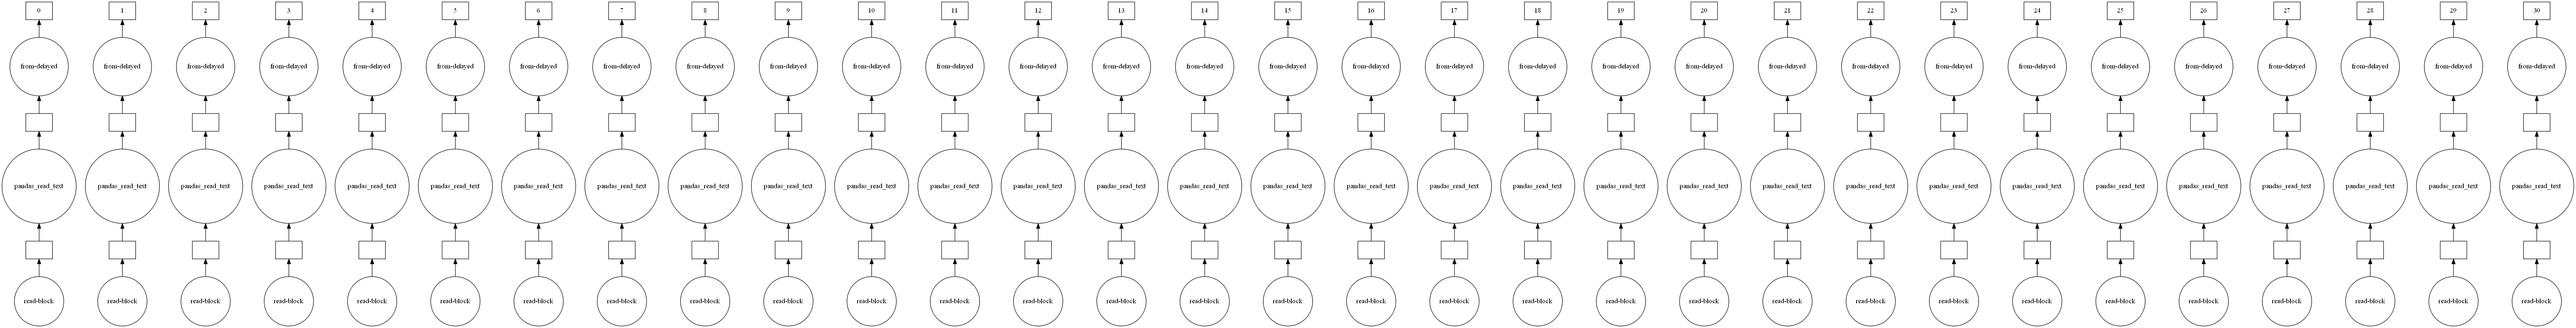

In [3]:
#dask.dataframe doesnot trigger imediate computation 
#Instead they add key-value pairs to unnderlying Dask Graph . Circles are operations and rectangles are results
month.visualize()

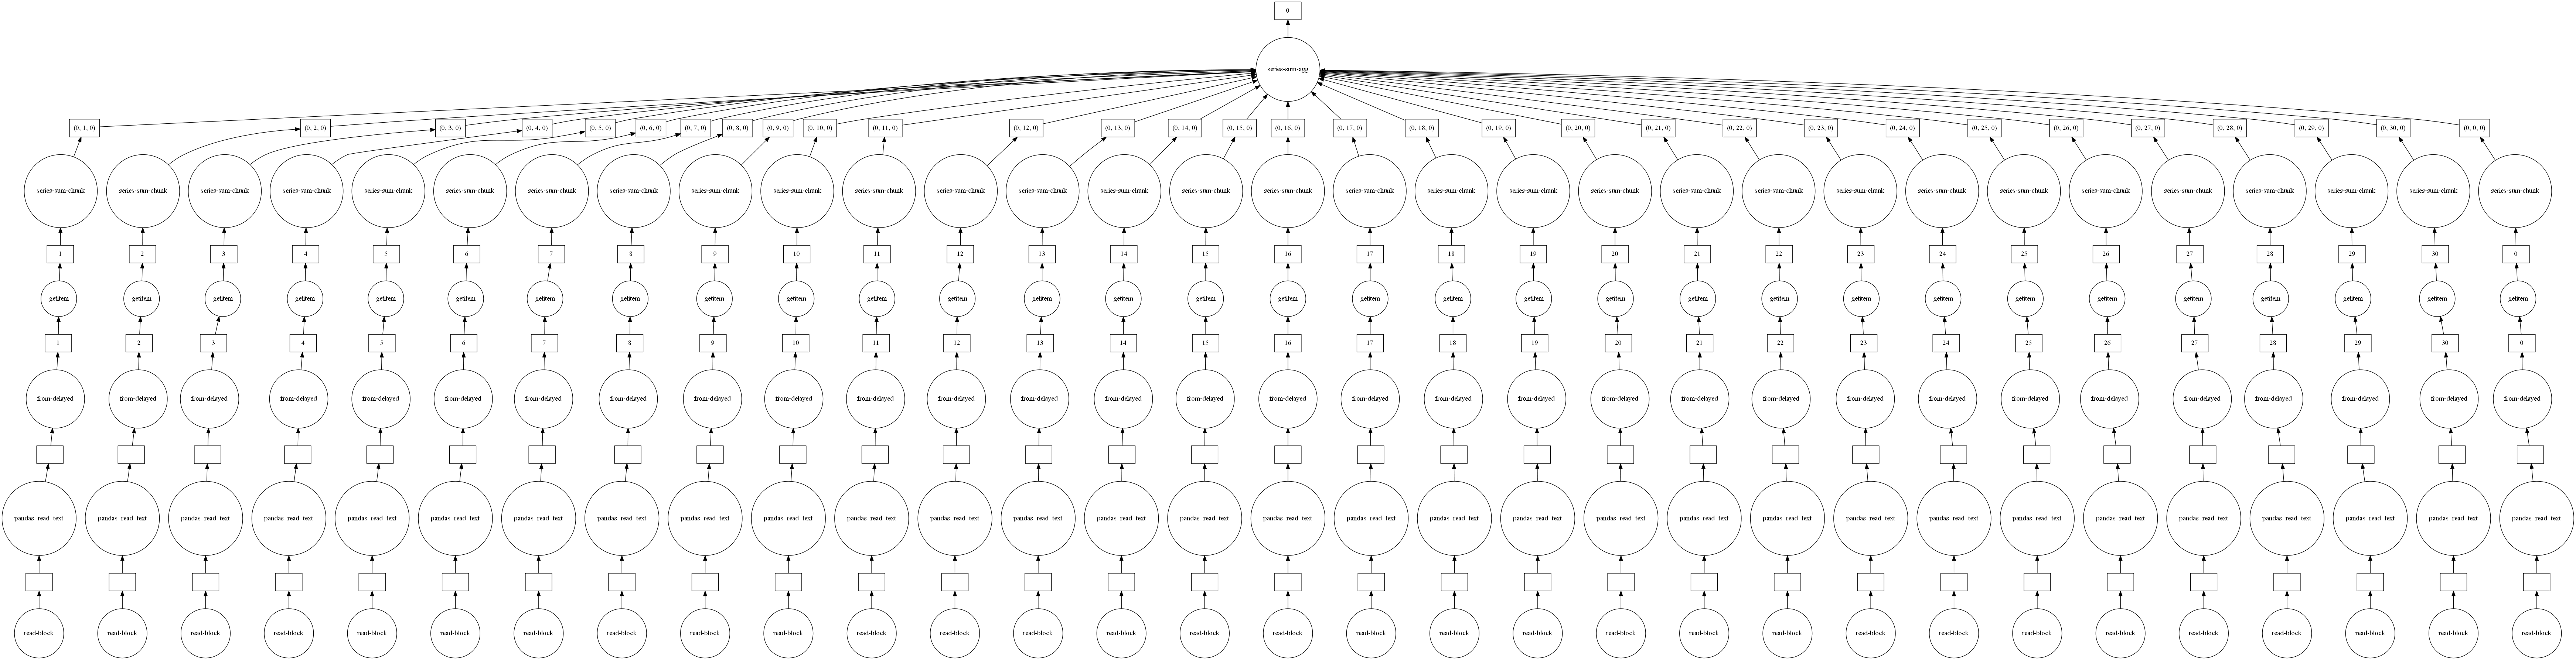

In [4]:
month.fare_amount.sum().visualize()

## Performance marix for the Problem

1. Mean Absolute Percentage Error

2. Mean Square Error

In [5]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-02-08 11:33:46,2015-02-08 11:37:45,1,0.56,-73.949905,40.717438,1,N,-73.950012,40.724010,1,4.5,0.0,0.5,1.06,0.0,0.3,6.36
1,2,2015-02-28 23:52:39,2015-03-01 00:00:03,1,1.24,-73.983498,40.756104,1,N,-73.989540,40.767860,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
2,2,2015-02-28 23:52:39,2015-03-01 00:03:25,1,2.07,-74.003189,40.733059,1,N,-73.992363,40.715099,1,10.0,0.5,0.5,2.26,0.0,0.3,13.56
3,2,2015-02-28 23:52:39,2015-03-01 00:04:58,1,2.29,-73.958549,40.760479,1,N,-73.979248,40.736660,1,10.5,0.5,0.5,2.36,0.0,0.3,14.16
4,2,2015-02-28 23:52:39,2015-03-01 00:00:16,1,1.36,-73.974052,40.751335,1,N,-73.981789,40.763149,1,7.0,0.5,0.5,1.00,0.0,0.3,9.30


## 1.1 Pickup Latitude and Longitude 

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.

In [7]:
#pickup latitude and  longitude details are not  given in the new datasets
outlier_locations = month[(month.pickup_longitude<=-74.15)|
                          (month.pickup_latitude<=40.57754)|(month.pickup_longitude >= -73.7004)|(month.pickup_latitude>=40.9176)]

#Creating the map ith base loocation

map_osm = folium.Map(location=[40.73469,-73.990372],titles='Stamen Toner')

sample_location = outlier_locations.head(10000)
for i,j in sample_location.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
        
map_osm        
                       

## 1.2 Dropoff latitude longitude

In [8]:
#pickup latitude and  longitude details are not  given in the new datasets
outlier_locations = month[(month.pickup_longitude<=-74.15)|
                          (month.pickup_latitude<=40.57754)|(month.pickup_longitude >= -73.7004)|(month.pickup_latitude>=40.9176)]

#Creating the map ith base loocation

map_osm = folium.Map(location=[40.73469,-73.990372],titles='Stamen Toner')

sample_location = outlier_locations.head(10000)
for i,j in sample_location.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
        
map_osm        

## 2. Trip duration

The maximum trip duration that a acn  can have is 12 hours

In [9]:
##Converting the timestamp into Unix timestamp
import time
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s,"%Y-%m-%d %H:%M:%S").timetuple())

In [10]:
#program to return the return time in trip

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()#compuute is used for dask
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_dropoff = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate the duration of triips
    durations= (np.array(duration_dropoff)-np.array(duration_pickup))/float(60)
    
    #append new features i.e duration and speed in miles per hour in the new dataframes
    
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame    

In [11]:
frames_with_durations = return_with_trip_times(month)

In [28]:
frames_with_durations['trip_times'] = frames_with_durations['trip_times']*float(60)

In [29]:
frames_with_durations.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude,total_amount,trip_times,pickup_times,speed
0,1,0.56,-73.949905,40.717438,40.724010,-73.950012,6.36,3.983333,1.423375e+09,8.435146
1,1,1.24,-73.983498,40.756104,40.767860,-73.989540,9.36,7.400000,1.425148e+09,10.054054
2,1,2.07,-74.003189,40.733059,40.715099,-73.992363,13.56,10.766667,1.425148e+09,11.535604
3,1,2.29,-73.958549,40.760479,40.736660,-73.979248,14.16,12.316667,1.425148e+09,11.155616
4,1,1.36,-73.974052,40.751335,40.763149,-73.981789,9.30,7.616667,1.425148e+09,10.713348


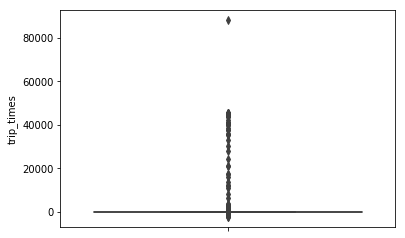

In [30]:
#the skewed box plot show use prescence of outliers
sns.boxplot(y='trip_times',data=frames_with_durations)

In [31]:
#calculating 0-100th percentile to find the correct percentile value for the removal of outlier
for i in range(0,100,10):
    var = frames_with_durations['trip_times'].values
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

0 percentile value is -2676.133333333333
10 percentile value is 4.033333333333333
20 percentile value is 5.716666666666667
30 percentile value is 7.3
40 percentile value is 8.95
50 percentile value is 10.766666666666667
60 percentile value is 12.9
70 percentile value is 15.583333333333334
80 percentile value is 19.3
90 percentile value is 25.633333333333333
100 percentile value is 88211.26666666666


In [32]:
#looking further from 99th percentiles
for i in range(90,100):
    var = frames_with_durations['trip_times'].values
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

90 percentile value is 25.633333333333333
91 percentile value is 26.616666666666667
92 percentile value is 27.7
93 percentile value is 28.966666666666665
94 percentile value is 30.449999999999996
95 percentile value is 32.21666666666667
96 percentile value is 34.46666666666667
97 percentile value is 37.46666666666667
98 percentile value is 42.03333333333333
99 percentile value is 50.7
100 percentile value is 88211.26666666666


In [33]:
#removing  the outlier from the duration data
frames_with_durations_modified = frames_with_durations[(frames_with_durations.trip_times>1) & (frames_with_durations.trip_times<720)]

In [34]:
frames_with_durations_modified.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude,total_amount,trip_times,pickup_times,speed
0,1,0.56,-73.949905,40.717438,40.724010,-73.950012,6.36,3.983333,1.423375e+09,8.435146
1,1,1.24,-73.983498,40.756104,40.767860,-73.989540,9.36,7.400000,1.425148e+09,10.054054
2,1,2.07,-74.003189,40.733059,40.715099,-73.992363,13.56,10.766667,1.425148e+09,11.535604
3,1,2.29,-73.958549,40.760479,40.736660,-73.979248,14.16,12.316667,1.425148e+09,11.155616
4,1,1.36,-73.974052,40.751335,40.763149,-73.981789,9.30,7.616667,1.425148e+09,10.713348


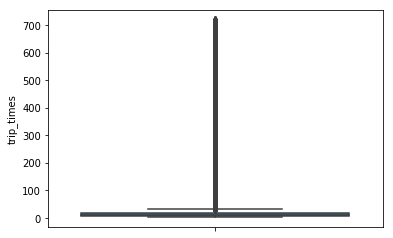

In [35]:
sns.boxplot(y='trip_times',data=frames_with_durations_modified)

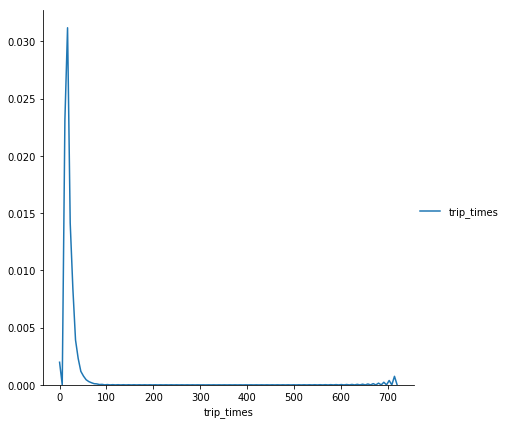

In [36]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frames_with_durations_modified,size=6).map(sns.kdeplot,'trip_times').add_legend()
plt.show()

In [37]:
#converting the values to log-values to check for log-normal
import math
frames_with_durations_modified['log_times']= [math.log(i) for i in frames_with_durations_modified['trip_times'].values]

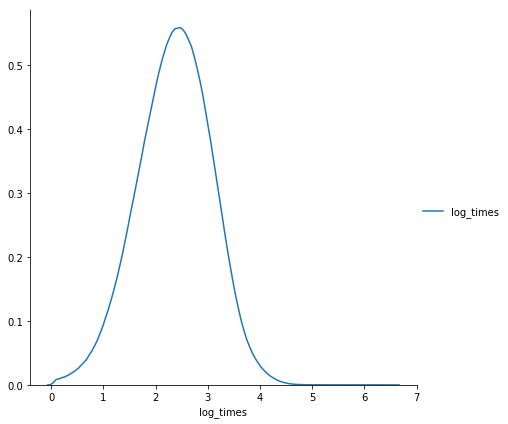

In [38]:
#pdf of log-values
sns.FacetGrid(frames_with_durations_modified,size=6).map(sns.kdeplot,'log_times').add_legend()
plt.show()

In [39]:
#Q-Q plot for checking if trip times is log normal
import scipy

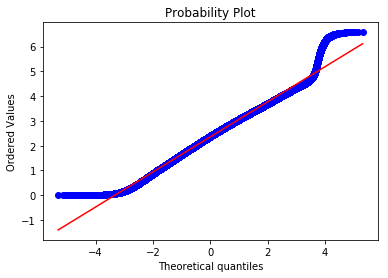

In [41]:
scipy.stats.probplot(frames_with_durations_modified['log_times'].values,plot=plt)
plt.show()

## 4 Speed

In [42]:
#check for any outlier in the data after trip duration outlier removed
#box-plot for speed for outliuers

frames_with_durations_modified['speed'] = 60*(frames_with_durations_modified['trip_distance']/frames_with_durations_modified['trip_times'])

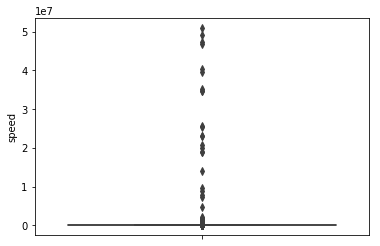

In [44]:
sns.boxplot(y='speed',data=frames_with_durations_modified)
plt.show()

In [47]:
#calculating speed values at each percentile
for i in range(0,100,10):
    var = frames_with_durations_modified['speed'].values
    var  = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

0 percentile value is 0.0
10 percentile value is 5.768545994065283
20 percentile value is 7.1146245059288535
30 percentile value is 8.212927756653992
40 percentile value is 9.25925925925926
50 percentile value is 10.344827586206897
60 percentile value is 11.557710960232784
70 percentile value is 13.046762589928058
80 percentile value is 15.160796324655436
90 percentile value is 19.236641221374047
100 percentile value is 51012145.74898786


In [48]:
#calculating the speed values at 90-100
for i in range(90,100):
    var = frames_with_durations_modified['speed'].values
    var  = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

90 percentile value is 19.236641221374047
91 percentile value is 19.93846153846154
92 percentile value is 20.745156482861404
93 percentile value is 21.685459940652816
94 percentile value is 22.78633623576691
95 percentile value is 24.114832535885167
96 percentile value is 25.71428571428571
97 percentile value is 27.713062098501076
98 percentile value is 30.400000000000002
99 percentile value is 34.524099722991686
100 percentile value is 51012145.74898786


In [49]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frames_with_durations_modified['speed'].values
    var  = np.sort(var,axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is",var[-1])

99.0 percentile value is 34.524099722991686
99.1 percentile value is 35.094339622641506
99.2 percentile value is 35.711645101663585
99.3 percentile value is 36.39130434782609
99.4 percentile value is 37.15776699029127
99.5 percentile value is 38.03773584905661
99.6 percentile value is 39.05325443786983
99.7 percentile value is 40.284191829484904
99.8 percentile value is 41.862655330281235
99.9 percentile value is 44.37754271765663
100 percentile value is 51012145.74898786


In [50]:
#removing further outliers based  on 99.9th percentile value
frames_with_durations_modified = frames_with_durations_modified[(frames_with_durations_modified.speed>0)&(frames_with_durations_modified.speed<45.31)]

In [51]:
#avgg-speed  of cabs in NY
sum(frames_with_durations_modified['speed'])/float(len(frames_with_durations_modified['speed']))

11.705702682879947

The avg speed in NY is 11.7, so cab driver 2 miles per 10 min

# 4. trip distance

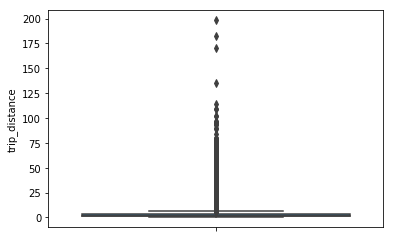

In [52]:
#plotting the box-plot of the distance
sns.boxplot(y='trip_distance',data=frames_with_durations_modified)
plt.show()

In [53]:
for i in range(0,100,10):
    var = frames_with_durations_modified['trip_distance']
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.4
50 percentile value is 1.7
60 percentile value is 2.1
70 percentile value is 2.67
80 percentile value is 3.66
90 percentile value is 6.1
100 percentile value is 198.77


In [54]:
for i in range(90,100):
    var = frames_with_durations_modified['trip_distance']
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

90 percentile value is 6.1
91 percentile value is 6.6
92 percentile value is 7.2
93 percentile value is 8.0
94 percentile value is 8.83
95 percentile value is 9.7
96 percentile value is 10.62
97 percentile value is 12.07
98 percentile value is 15.8
99 percentile value is 18.08
100 percentile value is 198.77


In [55]:
for i in np.arange(0.0,1.0,0.1):
    var = frames_with_durations_modified['trip_distance']
    var = np.sort(var,axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is",var[-1])

99.0 percentile value is 18.08
99.1 percentile value is 18.28
99.2 percentile value is 18.5
99.3 percentile value is 18.76
99.4 percentile value is 19.07
99.5 percentile value is 19.42
99.6 percentile value is 19.9
99.7 percentile value is 20.5
99.8 percentile value is 21.25
99.9 percentile value is 22.65
100 percentile value is 198.77


In [70]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frames_with_durations[(frames_with_durations.trip_distance>0) & (frames_with_durations.trip_distance<23)]

In [ ]:
sns.boxplot(y='trip_distance',data=frames_with_durations_modified)

## 5 Total Fare

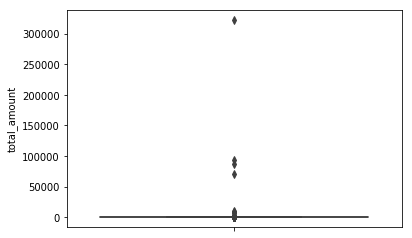

In [43]:
sns.boxplot(y='total_amount',data=frames_with_durations_modified)
plt.show()

In [46]:
for i in range (0,100,10):
    var = frames_with_durations_modified['total_amount'].values
    var = np.sort(var,axis=None)
    print('{} percentile value is {}'.format(i,var[int(len(var)*float(i)/100)]))
print('100 percentile value is ',var[-1])    

0 percentile value is -496.3
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.76
60 percentile value is 13.3
70 percentile value is 15.8
80 percentile value is 19.3
90 percentile value is 27.3
100 percentile value is  322743.82


In [64]:
for i in range (90,100):
    var = frames_with_durations_modified['total_amount'].values
    var = np.sort(var,axis=None)
    print('{} percentile value is {}'.format(i,var[int(len(var)*float(i)/100)]))
print('100 percentile value is ',var[-1])    

90 percentile value is 27.25
91 percentile value is 28.6
92 percentile value is 30.63
93 percentile value is 33.13
94 percentile value is 36.13
95 percentile value is 39.63
96 percentile value is 43.63
97 percentile value is 49.3
98 percentile value is 58.13
99 percentile value is 68.13
100 percentile value is  93964.16


In [59]:
for i in np.arange (0.0,1.0,0.1):
    var = frames_with_durations_modified['total_amount'].values
    var = np.sort(var,axis=None)
    print('{} percentile value is {}'.format(99+i,var[int(len(var)*float(99+i)/100)]))
print('100 percentile value is ',var[-1])    

99.0 percentile value is 68.13
99.1 percentile value is 69.6
99.2 percentile value is 69.73
99.3 percentile value is 69.76
99.4 percentile value is 69.76
99.5 percentile value is 69.76
99.6 percentile value is 72.63
99.7 percentile value is 73.13
99.8 percentile value is 80.56
99.9 percentile value is 96.05
100 percentile value is  93964.16


In [61]:
for i in np.arange (0.0,0.1,0.01):
    var = frames_with_durations_modified['total_amount'].values
    var = np.sort(var,axis=None)
    print('{} percentile value is {}'.format(99.9+i,var[int(len(var)*float(99.9+i)/100)]))
print('100 percentile value is ',var[-1])    

99.9 percentile value is 96.05
99.91000000000001 percentile value is 98.1
99.92 percentile value is 100.05
99.93 percentile value is 102.36
99.94000000000001 percentile value is 105.35
99.95 percentile value is 109.26
99.96000000000001 percentile value is 114.36
99.97 percentile value is 121.8
99.98 percentile value is 135.3
99.99000000000001 percentile value is 158.38
100 percentile value is  93964.16


The 99.999 point does not look like an  outlier, as there is  not much diffferentiate between 99.8 and 99.9

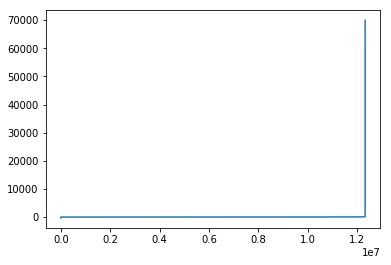

In [62]:
plt.plot(var[:-2])
plt.show()

A very sharp increase in fare values can be seen.
Plotting the last three total fare values

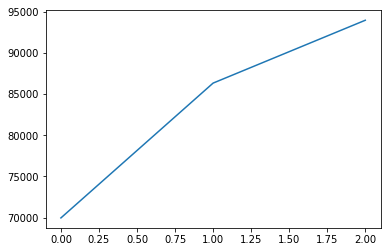

In [65]:
plt.plot(var[-3:])
plt.show()

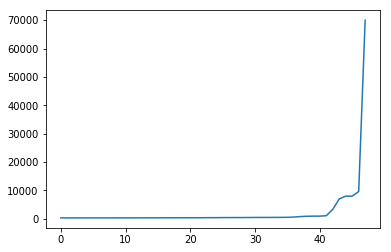

In [66]:
plt.plot(var[-50:-2])
plt.show()

## Remove all the outliers/errornous points

In [74]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.speed <= 65) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [75]:
print('Removing the outliers  in February 2015')
print('--------------------------------------')
frame_with_durations_outliers_removed = remove_outliers(frames_with_durations)
print('The fraction of data points after removing the ouutliers',float(len(frame_with_durations_outliers_removed))/len(frames_with_durations))

Removing the outliers  in February 2015
--------------------------------------
Number of pickup records =  12450521
Number of outlier coordinates lying outside NY boundaries: 296527
Number of outliers from trip times analysis: 24117
Number of outliers from trip distance analysis: 90085
Number of outliers from speed analysis: 25511
Number of outliers from fare analysis: 5341
Total outliers removed 375017
---
The fraction of data points after removing the ouutliers 0.9698794130783764


## Data preparation 

# Clustering and Segamentation

In [76]:
#trying different  cluuster sizes and choose the right k-menas

In [77]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.812169955437166 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7420690166698347 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 6.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 24.0 
Min inter-cluster distance =  0.3838526722880679 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance =

The Number of clusters , and the  average number of number  of cluster  with inter-cluster distace less than 2 and  average number of clusters ouutside the vicinity  and  the minimum inter cluster distance should be more such that no more clusters are  nearby.

# Inference

The main objective  was to find  an optimal min distance (which roughly estimate the radius  of ourv cluster) between the clustter which we got 40.

# Plotting the clusters centers

In [ ]:
#if check for the 50 clusters you can observe that there are two clusters with only 0.3 mile apart from each other , so we choose 40
#clusters for solving the further problem

#Getting 40 clusters using k-means

kmeans = MiniBatchKMeans(n_clusters=40 , batch_size=10000, random_state = 0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude','pickup_longitude']])

# Plotting the clusters centers

In [82]:
#plotting the clusters center  an OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(locations=[40.734695,-73.990372],titles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])),popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm    

# Plotting the clusters

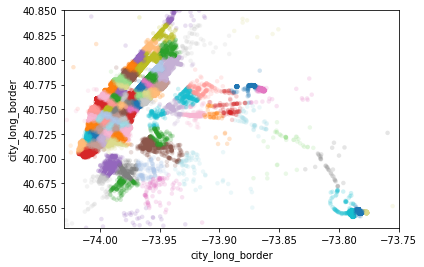

In [85]:
#visualising tthe  clusters on map
def plot_clusters(frame):
    city_long_border=(-74.03,-73.75)
    city_lat_border = (40.63,40.85)
    fig,ax = plt.subplots(ncols=1,nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=20,lw=0, 
               c=frame.pickup_cluster.values[:100000],cmap='tab20',alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('city_long_border')
    ax.set_ylabel('city_long_border')
    plt.show()
    
plot_clusters(frame_with_durations_outliers_removed)
    

# TimeBinning

In [86]:
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-2]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [88]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
feb_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,2,2015)
feb_2015_groupby = feb_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [91]:
feb_2015_frame.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude,total_amount,trip_times,pickup_times,speed,pickup_cluster,pickup_bins
0,1,0.56,-73.949905,40.717438,40.724010,-73.950012,6.36,3.983333,1.423375e+09,8.435146,11,5541
1,1,1.24,-73.983498,40.756104,40.767860,-73.989540,9.36,7.400000,1.425148e+09,10.054054,32,8495
2,1,2.07,-74.003189,40.733059,40.715099,-73.992363,13.56,10.766667,1.425148e+09,11.535604,2,8495
3,1,2.29,-73.958549,40.760479,40.736660,-73.979248,14.16,12.316667,1.425148e+09,11.155616,7,8495
4,1,1.36,-73.974052,40.751335,40.763149,-73.981789,9.30,7.616667,1.425148e+09,10.713348,18,8495


In [92]:
feb_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              4464                   219
               4465                   257
               4466                   211
               4467                   222
               4468                   183

In [94]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    

month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')



feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)


Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..


# Smoothing

In [93]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [96]:
feb_2015_unique = return_unq_pickup_bins(feb_2015_frame)
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

In [98]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(feb_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  432
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  532
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  432
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  832
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  432
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  432
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  434
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  432
-----

In [100]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [101]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [102]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
feb_2015_fill = fill_missing(feb_2015_groupby['trip_distance'].values,feb_2015_unique)

#Smoothing Missing values of Jan-2015
feb_2015_smooth = smoothing(feb_2015_groupby['trip_distance'].values,feb_2015_unique)

In [103]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(feb_2015_fill))

number of 10min intravels among all the clusters  178560


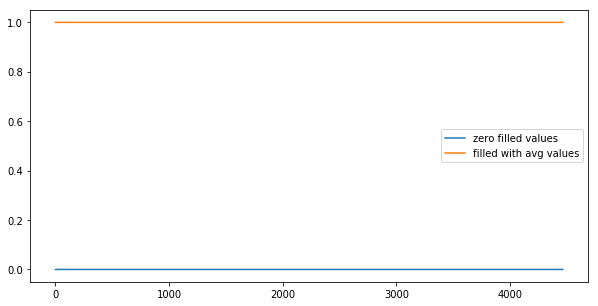

In [106]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(feb_2015_fill[:4464], label="zero filled values")
plt.plot(feb_2015_smooth[:4464], label="filled with avg values")
plt.legend()
plt.show()

In [108]:
feb_2015_smooth = smoothing(feb_2015_groupby['trip_distance'].values,feb_2015_unique)

In [111]:
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)

In [112]:
regions_cum=[]
for i in range(0,40):
    regions_cum.append(feb_2016_smooth[4464*i:4464*(i+1)])


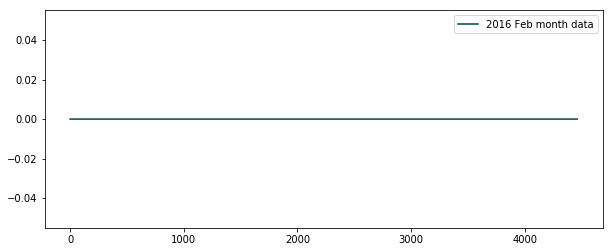

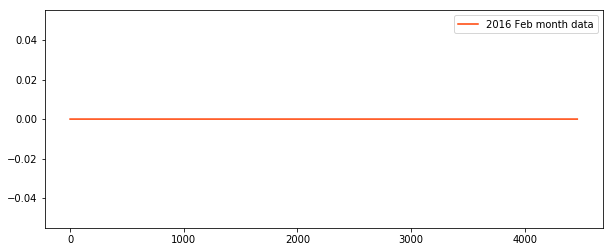

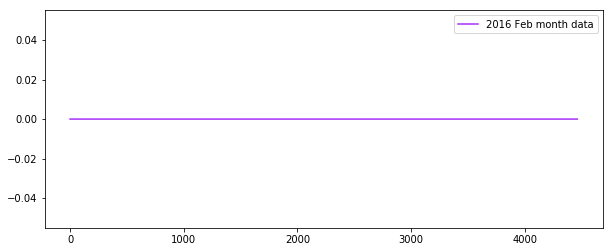

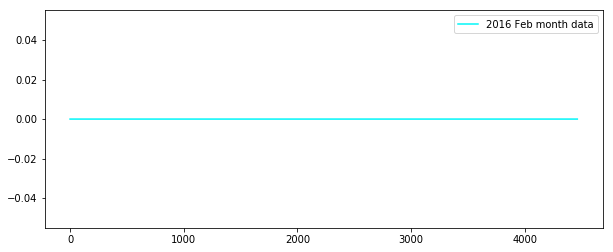

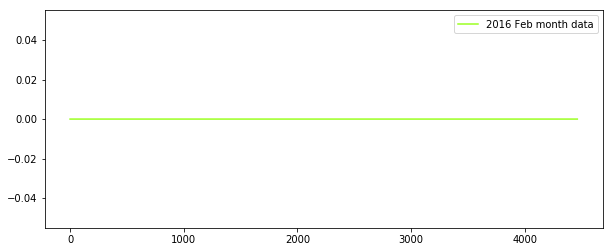

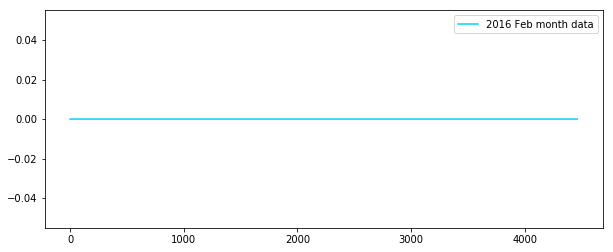

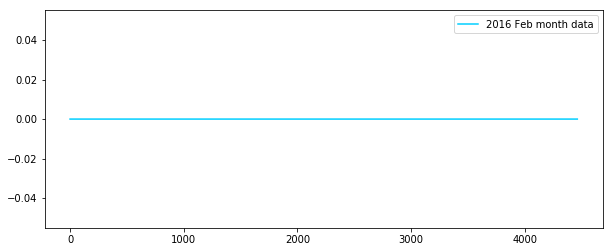

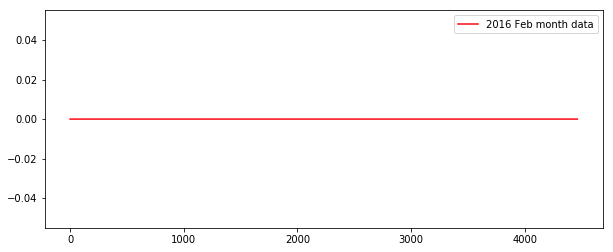

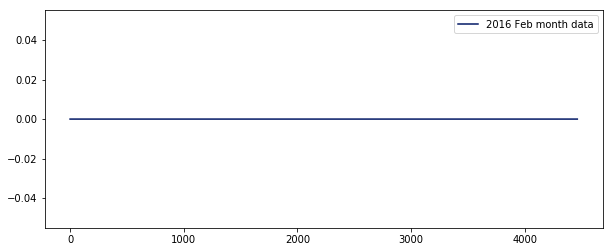

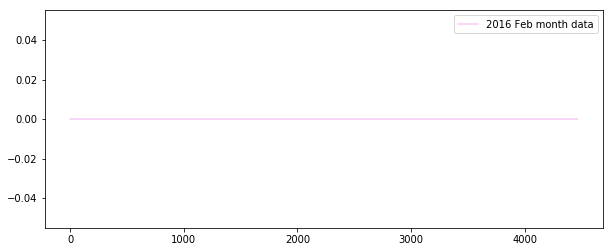

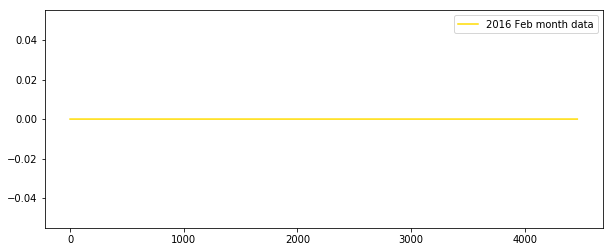

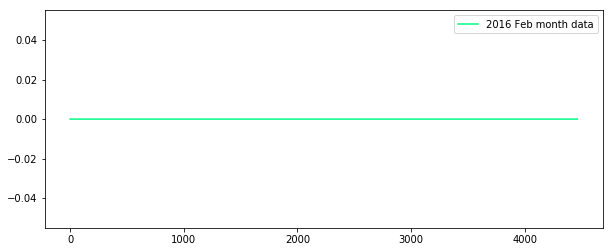

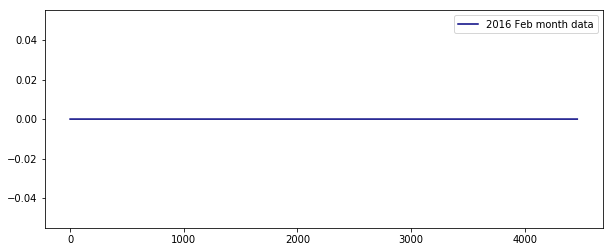

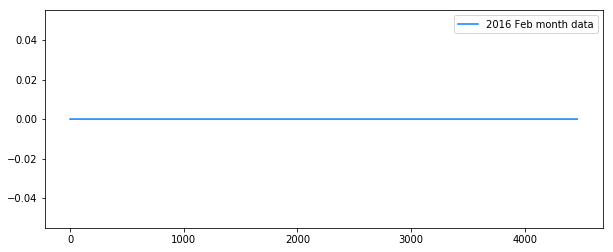

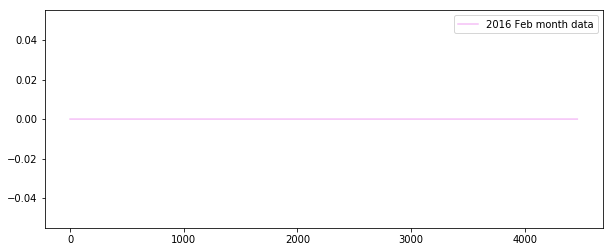

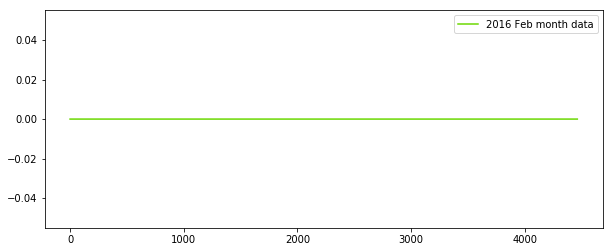

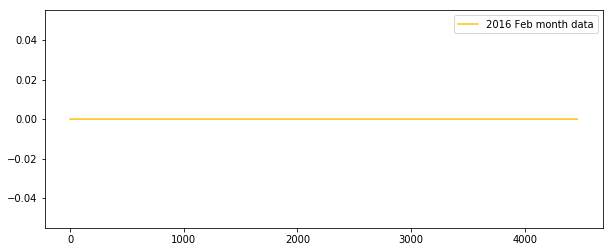

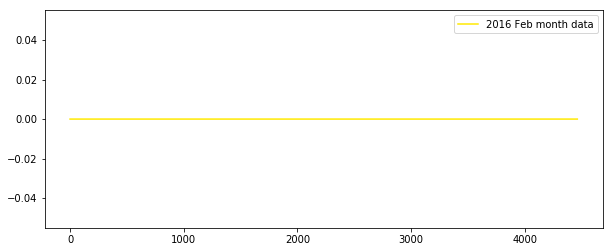

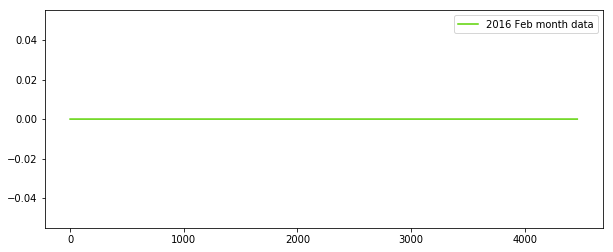

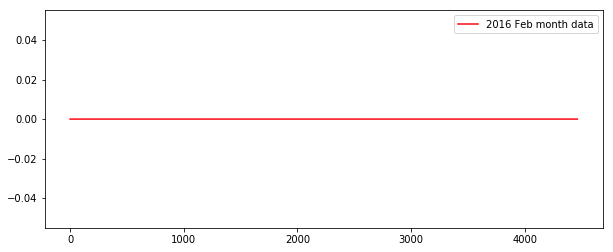

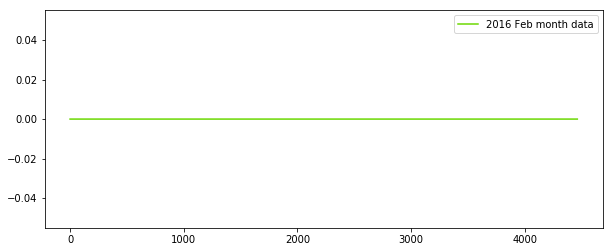

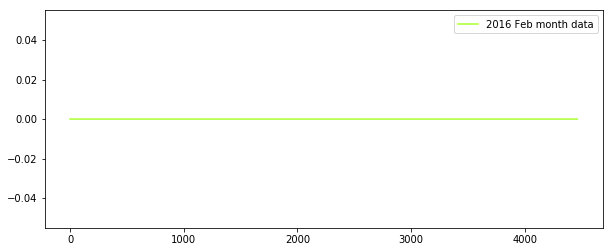

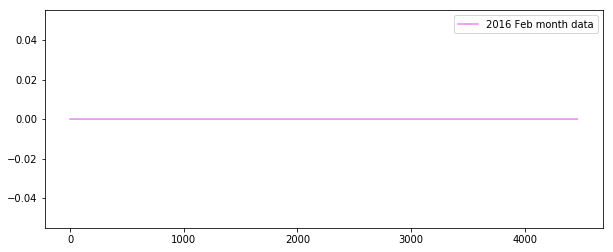

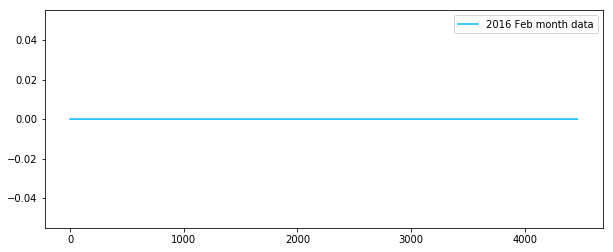

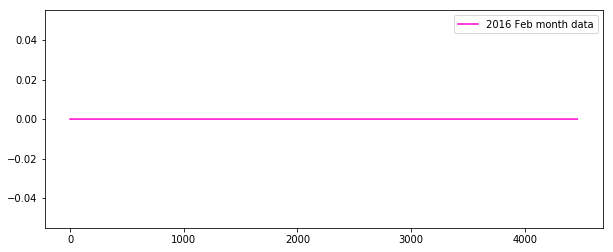

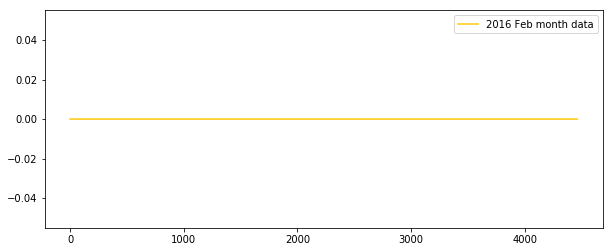

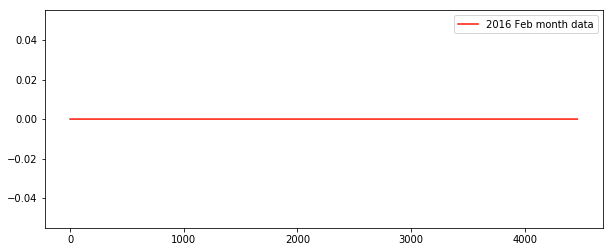

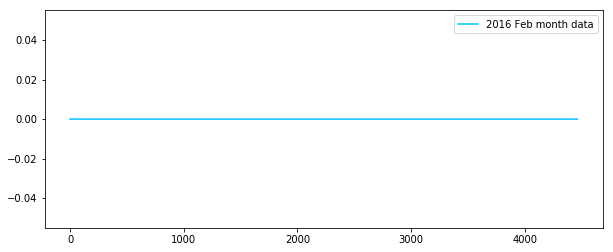

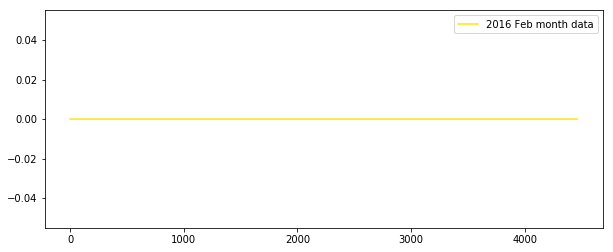

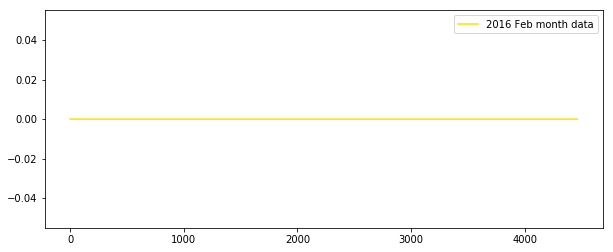

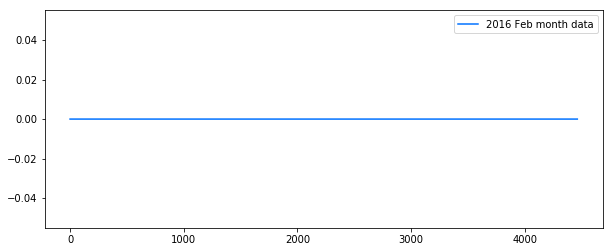

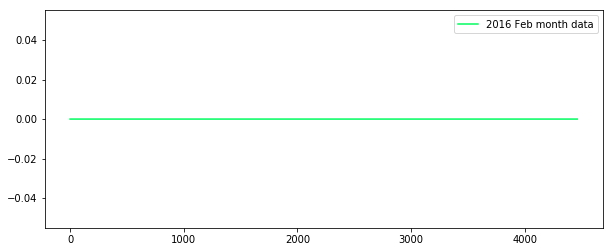

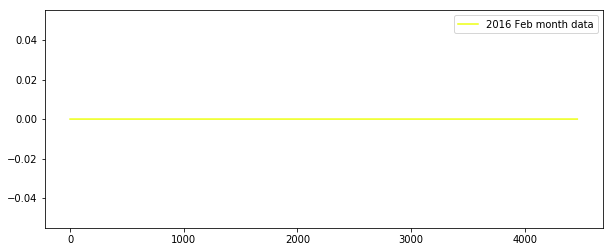

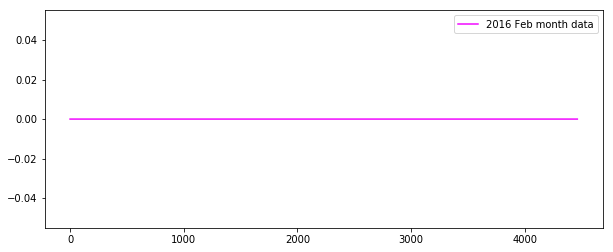

KeyboardInterrupt: 

In [114]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
# second_x = list(range(4464,8640))
# third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Feb month data')
#     plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
#     plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()